In [1]:
import warnings
warnings.filterwarnings('ignore')

# <span style="color:Maroon">Case Study: Usage of Data Science in Entertainment Industry.

#### <span style="color:Green">Select optimal advetisement to display in break time for a TV Show, based on what was recently shown in the TV

## <span style="color:Maroon">Random Forest Model

<span style="color:Green">A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement

<span style="color:Green">The hyperparameters available for random forests are:
    
<span style="color:Green">$\;\;\;\;\;\;$1. Number of trees: Total number of trees to be built in final model
    
<span style="color:Green">$\;\;\;\;\;\;$2. Depth:Max depth allowed for each tree
    
<span style="color:Green">$\;\;\;\;\;\;$3. Minimum Sample split: Minimum observations in a node to split
    
<span style="color:Green">$\;\;\;\;\;\;$4. Minimum samples leaf: Minimum number of observations in a leaf node
    
<span style="color:Green">$\;\;\;\;\;\;$5. Max features: Number of features (Randomly) selected to build a tree

<span style="color:Green">Since the random forest is based on idea of bootstrapping and aggregating the results, it is referred to as a *bagging* ensemble model.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import os as os
np.random.seed(0)
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [3]:
# Setting the working directory to the folder
direc = os.getcwd()
os.chdir("..//Data//")

In [4]:
# Read the data in pandas dataframe
data = pd.read_csv("Dataset.csv")
data = data.fillna(0)

In [5]:
# Dependent variable (is given name of target)
target = 'h_food_str'
# Other dependent variables (These should be dropped from our dataset)
dv_list = ['h_alcohol_str', 'h_hot_drink_str', 'h_phone_str']
# drop the dv_list from the data (as In future, these labels won't be available to us (dv_list).
# Hence, for our modeling purpose, these variables are being dropped from the data.)
data = data.drop(dv_list, axis=1)

In [6]:
# One hot encoding of 'show_name' variable
df1 = pd.get_dummies(data['show_name'], prefix = 'show_name')
data = data.join(df1)
data.head()

,show_name,time_offset,r_abies,r_abyssinian,r_accessories,r_accipiter,r_acorn,r_adapter,r_adorable,r_adventure,...,r_zoo,h_food_str,show_name_fresh_meat,show_name_friday_night_dinner,show_name_hollyoaks,show_name_made_in_chelsea,show_name_made_in_chelsea_la,show_name_my_mad_fat_diary,show_name_peep_show,show_name_the_inbetweeners
0,fresh_meat,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,fresh_meat,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
2,fresh_meat,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
3,fresh_meat,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
4,fresh_meat,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0


### <span style="color:Maroon">Train-Test Split
<span style="color:Green">Divide the data in 70:30 ratio for training the model and validating the model

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop([target],axis=1), data[target], test_size=0.30, 
                                                    random_state=12345)

In [9]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [10]:
# Check if the random samples have similar mean
print (f"Train Dependent variable: {np.round(np.mean(y_train)*100,2)}")
print (f"Test Dependent variable: {np.round(np.mean(y_test)*100,2)}")

Train Dependent variable: 8.83
Test Dependent variable: 8.85


<span style="color:Blue">__Comments:__ The means of dependent variable are very similar in test and train dataset

### <span style="color:Maroon">Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

In [12]:
# Actual data with one hot encoding for show_name
data_rf = data.drop(["show_name","time_offset"], axis=1)

###### <span style="color:Maroon">Variable Reduction using Random Forest:
    
<span style="color:Green">To select the top N variables, we will use the Random Forest Variable Importance metrics to reduce the variables. The process for the same is: 
    
<span style="color:Green">$\;\;\;\;\;\;$1. Build a RF model with all variables and Number of trees (n_estimators) = 10 X (NumberOfVariables)
    
<span style="color:Green">$\;\;\;\;\;\;$2. Calculate variable importance for all the variables
    
<span style="color:Green">$\;\;\;\;\;\;$3. Drop all the variables with Variable Importance == 0 and Combined cumulative importance (Sorted by Importance in descending order) < 0.98
    
<span style="color:Green">$\;\;\;\;\;\;$4. Repeat the steps 1 to 3, till RF can no longer drop any variable based on variable Importance
        
For more details on "variable importance metrics" for Random Forest, please refer the below link:       https://www.displayr.com/how-is-variable-importance-calculated-for-a-random-forest/

In [13]:
# Variable reduction using random forest
def varred_rf(X, y, independent_vars):
    X_reduce = X[independent_vars]
    # Number of trees = 10 x number of variables
    ntrees = min(1000, 10*len(independent_vars))
    clf = RandomForestClassifier(n_estimators=ntrees, criterion='gini', min_samples_split=10, 
                                 max_features='sqrt', n_jobs=-1, random_state=12345)
    clf.fit(X_reduce,y)
    VarSel = pd.DataFrame(independent_vars)
    VarSel.columns = ["Variables"]
    VarSel["Importance"] = (clf.feature_importances_)
    VarSel = VarSel[VarSel["Importance"]>0.0001]
    VarSel = VarSel.sort_values(by="Importance", ascending = False)
    VarSel["Cumulative Importance"] = VarSel["Importance"].cumsum()
    VarSel = VarSel[VarSel["Cumulative Importance"] <= 0.98]
    return list(VarSel["Variables"])

<span style="color:Blue">__Comment:__ As the number of independent variales is really high, we shall drop all variables which fail the chi square test of independence at relaxed value of 0.10

In [14]:
# Split the data in train and test
data_X = data_rf.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_rf[target], test_size=0.30, random_state=12345)

In [15]:
# Variable reduction using random forest
independent_vars = list(X_train.columns)
flag_stop = True

while(flag_stop):
    bf_len = len(independent_vars)
    independent_vars = varred_rf(X_train,y_train, independent_vars)
    print("{} independent variables left".format(len(independent_vars)))
    if(bf_len <= 200):
        flag_stop=False

354 independent variables left
273 independent variables left
232 independent variables left
202 independent variables left
179 independent variables left
160 independent variables left


In [16]:
X_train_rf = X_train[independent_vars]
X_test_rf = X_test[independent_vars]
print ("Top {} variables were selected".format(len(independent_vars)))

Top 160 variables were selected


In [17]:
# Doing a random grid search to select the best Random Forest Model
from sklearn.model_selection import RandomizedSearchCV

# Declare the hyper-parameters for grid search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4]
bootstrap = [True, False]

In [18]:
# Random grid ***(Total 10*2*12*3*3*2) = 4320 models will be built ***
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [19]:
# RF Model
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3,
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [20]:
best_random = rf_random.best_estimator_
best_random

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
# RF model selected using Grid search
clf = best_random

In [22]:
os.chdir("..//Images//")

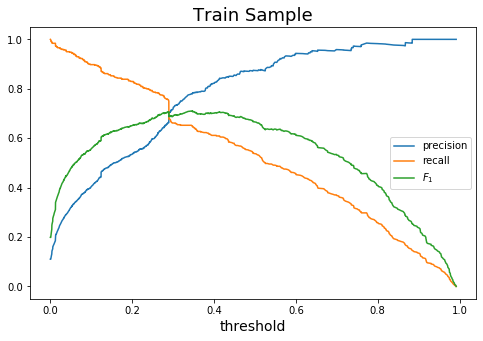

In [23]:
y_hat_test = clf.predict_proba(X_test_rf)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_hat_test[:,1])
f1_score = 2*precision*recall/(precision + recall)
threshold = np.hstack((0, threshold))
plt.figure(figsize=(8,5))
plt.plot(threshold, precision)
plt.plot(threshold, recall)
plt.plot(threshold, f1_score)
plt.xlabel('threshold', fontsize=14)
plt.title("Train Sample", fontsize=18)
plt.legend(['precision', 'recall', '$F_1$'])
plt.savefig("Train_RF_Precision_Recall_F1.png")
plt.show()

In [24]:
y_hat = clf.predict_proba(X_train_rf)
# Find the optimum threshold on propensity to tag class as 1 or 0
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_hat[:,1])
y_train_out = np.where(y_hat[:,1] > thresholds[np.argmax(tpr - fpr)],1,0)
# Performance metrics of the model

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
print("Performance Metrics for Training Sample")
print(classification_report(y_train, y_train_out))

tmp = pd.DataFrame(y_train)
tmp.columns = ["Actual"]
tmp["Predicted"] = y_train_out
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("\nConfusion Matrix\n")
print(pd.crosstab(tmp["Actual"],tmp["Predicted"]))

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Performance Metrics for Training Sample
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10573
           1       0.69      0.94      0.79      1024

    accuracy                           0.96     11597
   macro avg       0.84      0.95      0.89     11597
weighted avg       0.97      0.96      0.96     11597

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Confusion Matrix

Predicted      0    1
Actual               
0          10142  431
1             65  959


In [25]:
# Scoring test data and analyzing performance
y_hat = clf.predict_proba(X_test_rf)
y_test_out = np.where(y_hat[:,1] > thresholds[np.argmax(tpr - fpr)],1,0)
# Performance metrics of the model

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
print("Performance Metrics for Training Sample")
print(classification_report(y_test, y_test_out))

tmp = pd.DataFrame(y_test)
tmp.columns = ["Actual"]
tmp["Predicted"] = y_test_out
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("\nConfusion Matrix\n")
print(pd.crosstab(tmp["Actual"],tmp["Predicted"]))

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Performance Metrics for Training Sample
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4531
           1       0.59      0.80      0.67       440

    accuracy                           0.93      4971
   macro avg       0.78      0.87      0.82      4971
weighted avg       0.94      0.93      0.94      4971

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Confusion Matrix

Predicted     0    1
Actual              
0          4283  248
1            90  350


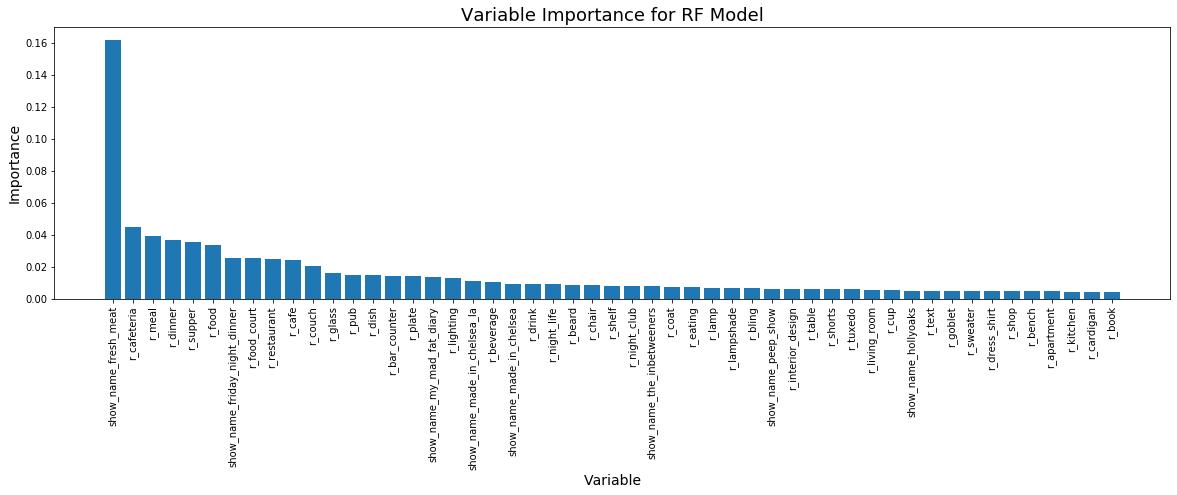

In [26]:
# Plot Variable Importance of the features in the final Model (for top cumulative contribution of 90%)
clf = best_random
plt.rcParams['figure.figsize'] = [20, 5]
variable_importance = clf.feature_importances_
variables = list(X_train_rf.columns)
importance = pd.DataFrame(variables)
importance.columns = ["Variables"]
importance["Importance"] = variable_importance
importance = importance.sort_values("Importance", ascending = False)
importance["cum_imp"] = importance["Importance"].cumsum()
importance = importance[importance["cum_imp"] <= 0.8]
plt.bar(importance["Variables"], importance["Importance"])
plt.xlabel("Variable", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.title("Variable Importance for RF Model", fontsize=18) 
plt.xticks(rotation=90)
plt.savefig("VariableImportance_RF_Train.png")
plt.show()

<span style="color:Blue">__Comments:__ The random forest model does really well, compared to the Naive classifer and logistic regression on all metrics. It has an accuracy of 93% on test sample, a recall of 79% and precision of 59%. 